# Training CNN Model

In [1]:
import os
import sys

sys.path.append('..')

In [2]:
from collections import Counter
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from src import FacialEmotionDataLoader
from src import FacialEmotionCNN

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Load Data

In [4]:
dataset_path = '../data'
batch_size = 32

data_loader = FacialEmotionDataLoader(dataset_path=dataset_path, model_type='cnn', batch_size=batch_size)
train_loader, test_loader, class_names = data_loader.get_data_loaders()

In [5]:
with open("../output/class_counts.json", "r") as f:
    counts_dict = json.load(f)

counts_list = [counts_dict[class_name] for class_name in class_names]
print(f"Loaded Class Counts: {counts_list}")

Loaded Class Counts: [1313, 3740, 4027, 3934, 1234]


In [6]:
total_samples = sum(counts_list)
class_weights = [total_samples / c for c in counts_list]
print(f"Class Weights: {class_weights}")

Class Weights: [10.851485148514852, 3.809625668449198, 3.5381177054879562, 3.6217590238942554, 11.546191247974068]


In [7]:
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
model = FacialEmotionCNN(num_classes=len(class_names)).to(device)

### Training Setup

In [8]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50

train_loss_history = list()
test_loss_history = list()

best_test_loss = float('inf')
patience = 5
early_stop_counter = 0
early_stop_threshold = 0.005

In [9]:
os.makedirs('../output', exist_ok=True)

### Training Loop

In [10]:
print('Starting training...\n')

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    loss_improvement = best_test_loss - avg_test_loss

    if loss_improvement >= early_stop_threshold:
        best_test_loss = avg_test_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), '../output/cnn_best_model.pth')
        print('Model improved. Saving checkpoint...')
    else:
        early_stop_counter += 1
        print(f'No significant improvement (Δ {loss_improvement:.6f}).')
        if early_stop_counter >= patience:
            print('Early stopping triggered.')
            break

print('\nTraining complete.')

Starting training...

Epoch [1/50], Train Loss: 1.4716, Test Loss: 1.3667
Model improved. Saving checkpoint...
Epoch [2/50], Train Loss: 1.2490, Test Loss: 1.1166
Model improved. Saving checkpoint...
Epoch [3/50], Train Loss: 1.1107, Test Loss: 1.1305
No significant improvement (Δ -0.013877).
Epoch [4/50], Train Loss: 1.0232, Test Loss: 1.1002
Model improved. Saving checkpoint...
Epoch [5/50], Train Loss: 0.9735, Test Loss: 1.0196
Model improved. Saving checkpoint...
Epoch [6/50], Train Loss: 0.8721, Test Loss: 0.7961
Model improved. Saving checkpoint...
Epoch [7/50], Train Loss: 0.8203, Test Loss: 0.8550
No significant improvement (Δ -0.058906).
Epoch [8/50], Train Loss: 0.7864, Test Loss: 0.8420
No significant improvement (Δ -0.045927).
Epoch [9/50], Train Loss: 0.7655, Test Loss: 0.9011
No significant improvement (Δ -0.105012).
Epoch [10/50], Train Loss: 0.7494, Test Loss: 0.7586
Model improved. Saving checkpoint...
Epoch [11/50], Train Loss: 0.6828, Test Loss: 0.7155
Model improved

### Evaluation

In [11]:
model.eval()
all_preds = list()
all_labels = list()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Test Accuracy: 73.40%
Precision: 0.7143
Recall: 0.7483
F1 Score: 0.7275

Classification Report:
              precision    recall  f1-score   support

       Angry       0.59      0.79      0.68       279
       Happy       0.89      0.91      0.90       750
     Neutral       0.67      0.65      0.66       750
         Sad       0.72      0.62      0.67       824
    Surprise       0.70      0.77      0.73       247

    accuracy                           0.73      2850
   macro avg       0.71      0.75      0.73      2850
weighted avg       0.74      0.73      0.73      2850



### Plot Training Loss

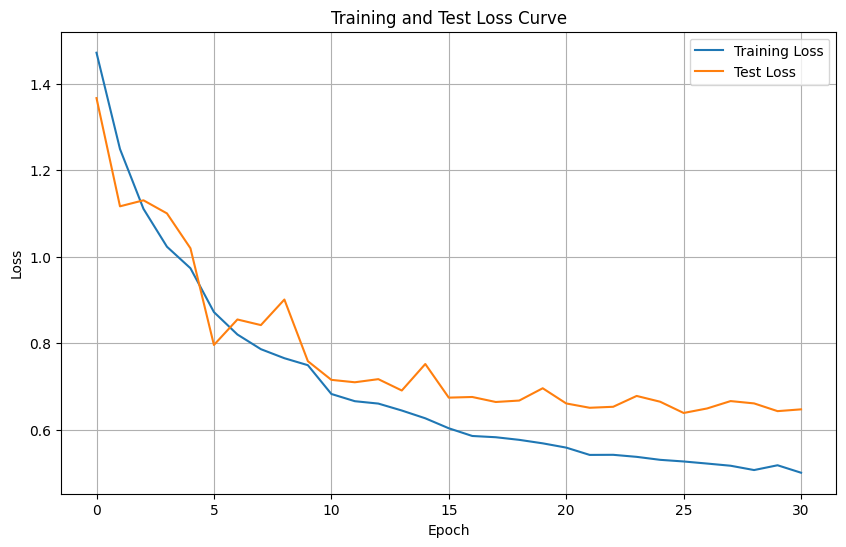

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid()
plt.show()

### Plot Confusion Matrix

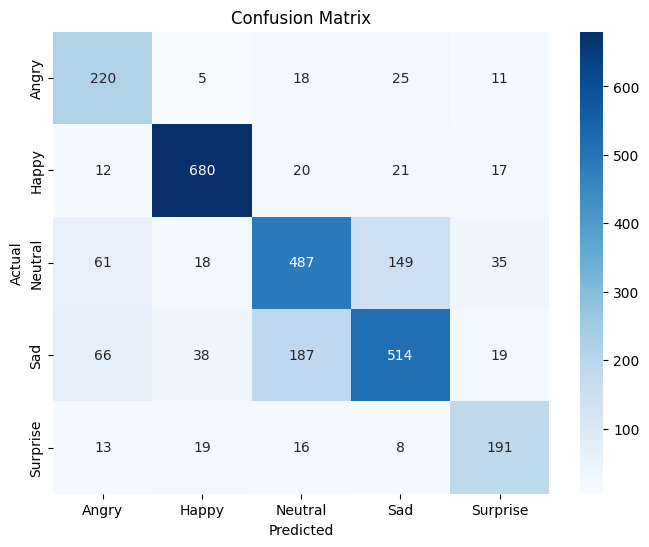

In [13]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---